###Pumping test analysis of a constant-rate pumping test in an anisotropic unconfined aquifer
The description and data for this example are taken from the [aqtesolve](http://www.aqtesolv.com/examples/ione.htm) website. 

Lohman (1972) presented data from a constant-rate pumping test performed in an unconfined aquifer with delayed gravity response near Ione, Colorado. The thickness of the unconfined alluvium was 39.4 ft. The fully penetrating test well pumped at a rate of 1170 gallons-per-minute (gpm) for 4270 minutes. The drawdown data were recorded in an observation well  located 63 ft from the test well at a depth of 19.7 ft below the static water surface.

In [1]:
from ttim import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin
import pandas as pd
%matplotlib inline

In [2]:
# problem definition
H = 39.4 * 0.3048                         # thickness [meters]
xw, yw = 0, 0                             # location well
xp, yp = 63 * 0.3048, 0                   # Location piezometer [meter]
Qw = 1170 * 5.45                          # discharge well in [m3/d]
z_obswell = -19.7 * 0.3048        # elevation of observation well

In [3]:
# loading data
data = np.loadtxt('pumptest_neuman.txt')         # time and drawdown
time, dd = data[:,0], data[:,1] 
td = time / 60 / 24                       # t in [days]
ho = -dd * 0.3048                         # observed head [meter]
print 'minimum and maximum time:', td.min(), td.max()

minimum and maximum time: 0.000694444444444 2.96527777778


In [4]:
# layer definition
Nlayers = 12                                    # number of layers
zlayers = np.linspace(0, -H, Nlayers + 1)
zcenter = 0.5 * (zlayers[:-1] + zlayers[1:])
layer_obswell = np.argmin(np.abs(z_obswell - zcenter))

Flow is simulated with a quasi three-dimensional model consisting of one aquifer which is divided into `Nlayers` model layers. The top and bottom of the aquifer are impermeable. The horizontal hydraulic conductivity $k$, phreatic storage $S_y$, elastic storage $S_s$, and vertical anisotropy $k_v/k_h$ are unkonwn. The variable `p` contains all unknown parameters. The well is modeled with the `Well` element. TTim divides the discharge along the layers such that the head is the same at the well in all screened layers.

In [5]:
def sse1(p, returnheads=False):  
    # Discharge distributed across layers by TTim
    Saq = p[2] * np.ones(Nlayers) # all layers except the top one have the same storage coefficient
    Saq[0] = p[1]
    ml = Model3D(kaq=p[0], z=zlayers, Saq=Saq, kzoverkh=p[3],
                 phreatictop=True, tmin=1e-4, tmax=10)  
    w = Well(ml, xw=xw, yw=yw, rw=0.3, tsandQ=[(0, Qw)], 
             layers=range(Nlayers))
    ml.solve(silent='.')
    hm = ml.head(xp, yp, td, layers=layer_obswell)
    if returnheads: return hm
    se = np.sum((hm[0] - ho)**2)
    return se

The `fmin` function from the `scipy.optimize` package is used to find the optimal set of parameters.

In [6]:
popt1 = fmin(sse1, [ 200,   1,   0.0005,   0.5])

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Optimization terminated successfully.
         Current function value: 0.007076
         Iterations: 163
         Function evaluations: 307



.


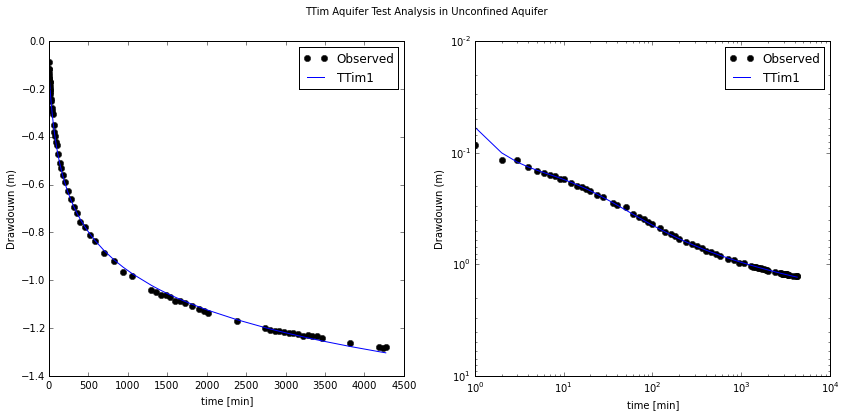

In [7]:
hm1 = sse1(popt1, returnheads=True)
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(time, ho, 'ko', label='Observed')
plt.plot(time, hm1[0], 'b', label='TTim1')
plt.xlabel('time [min]')
plt.ylabel('Drawdouwn (m)')
plt.legend(loc='best');
plt.subplot(122)
plt.loglog(time, -ho, 'ko', label='Observed')
plt.loglog(time, -hm1[0], 'b', label='TTim1')
plt.ylim(10, 0.01)
plt.xlabel('time [min]')
plt.ylabel('Drawdouwn (m)')
plt.legend(loc='best')
plt.suptitle('TTim Aquifer Test Analysis in Unconfined Aquifer');

In [8]:
r = pd.DataFrame(columns=['$T$ [ft$^2$/day]', '$S_y$', '$S$','$k_h/k_r$'],
                 index=['Lohman (1972)', 'AQTESOLV', 'TTim1'])
r.loc['Lohman (1972)'] = [22000, 0.2, 0, 0.3]
r.loc['AQTESOLV'] = [22980, 0.15, 0.008166, 0.25]
r.loc['TTim1'] = [popt1[0] * H / 0.0929, popt1[1], popt1[2] * H, popt1[3]]
r

,$T$ [ft$^2$/day],$S_y$,$S$,$k_h/k_r$
Lohman (1972),22000,0.2,0,0.3
AQTESOLV,22980,0.15,0.008166,0.25
TTim1,22896.48,0.1543743,0.009756421,0.1744148


This function is similar to 'sse1' except for the `Well` function. Here, a `DischargeWell` is used and the discharge is evenly divided over all the layers. 

In [9]:
Qp = Qw / Nlayers #deviding Qw over the layers equal

def sse2(p, returnheads = False):
    Saq = p[2] * np.ones(Nlayers)
    Saq[0] = p[1]
    ml = Model3D(kaq=p[0], z=zlayers, Saq=Saq, kzoverkh=p[3],
                 phreatictop=True, tmin= 1e-4, tmax=10)  
    w = DischargeWell(ml, xw=xw, yw=yw, rw=0.3, tsandQ=[(0, Qp)], 
                      layers=range(Nlayers))
    ml.solve(silent='.')
    hm = ml.head(xp, yp, td, layers=layer_obswell)
    if returnheads: return hm
    se = np.sum((hm[0] - ho)**2)
    return se

In [10]:
popt2 = fmin(sse2, [ 200,   1,   0.0005,   0.5])

Optimization terminated successfully.
         Current function value: 0.006349
         Iterations: 176
         Function evaluations: 329


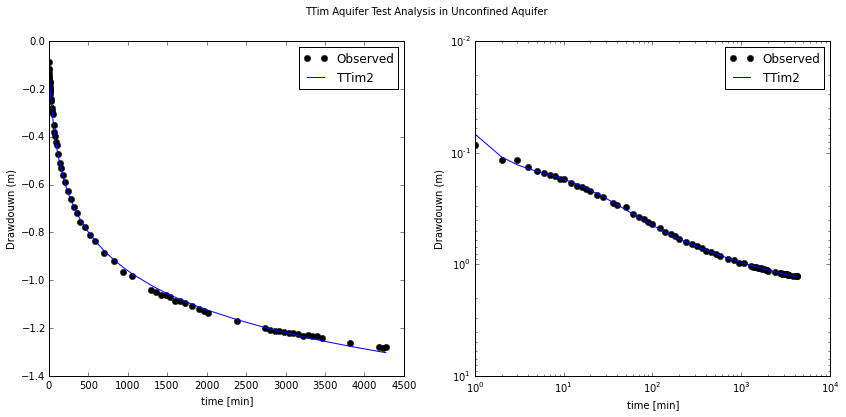

In [11]:
hm2 = sse2(popt2, returnheads = True)
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(time, ho, 'ko', label='Observed')
plt.plot(time, hm2[0], 'b', label='TTim2')
plt.xlabel('time [min]')
plt.ylabel('Drawdouwn (m)')
plt.legend(loc='best');
plt.subplot(122)
plt.loglog(time, -ho, 'ko', label='Observed')
plt.loglog(time, -hm2[0], 'b', label='TTim2')
plt.ylim(10, 0.01)
plt.xlabel('time [min]')
plt.ylabel('Drawdouwn (m)')
plt.legend(loc='best')
plt.suptitle('TTim Aquifer Test Analysis in Unconfined Aquifer');

In [12]:
r.loc['TTim2'] = [popt2[0] * H / 0.0929, popt2[1], popt2[2] * H, popt2[3]]
r

,$T$ [ft$^2$/day],$S_y$,$S$,$k_h/k_r$
Lohman (1972),22000,0.2,0,0.3
AQTESOLV,22980,0.15,0.008166,0.25
TTim1,22896.48,0.1543743,0.009756421,0.1744148
TTim2,22994.06,0.1520193,0.009489842,0.1921311
